# Automating QUBO Conversion

In [13]:
# !pip install numpy
# !pip install cplex
# !pip install qiskit-optimization

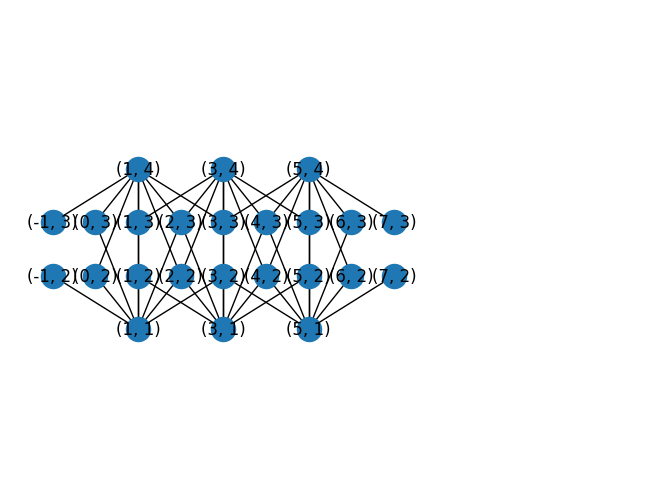

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()


points1 = [] #placement of lidars for one side
points2 = [] #placement of lidars for other side
points3 = [] #vertices to cover


for i in range(1, 6, 2):
    point = (i, 1)
    points1.append(point)

for i in range(1, 6, 2):
    point = (i, 4)
    points2.append(point)

for i in range(0, 7):
    for j in range(2, 4):
        point = (i, j)
        points3.append(point)

G.add_nodes_from(points1 + points2 + points3)

#edge that represents scope between lidar placement and vertices to cover
for node1 in points1:
  for j in range (node1[1]+1, node1[1]+3):
    if(j==node1[1]+1):
      for i in range(node1[0]-2, node1[0]+3):
        G.add_edge(tuple(node1), (i,j))
    if(j== node1[1]+2):
      for i in range(node1[0]-1, node1[0]+2):
        G.add_edge(tuple(node1), (i,j))
for node2 in points2:
  for j in range (node2[1]-2,node2[1]):
    if(j== node2[1]-2):
      for i in range(node2[0]-1, node2[0]+2):
        G.add_edge(tuple(node2), (i,j))
    if(j==node2[1]-1):
      for i in range(node2[0]-2, node2[0]+3):
        G.add_edge(tuple(node2), (i,j))
    

# Draw the graph
pos = {node: node for node in G.nodes()} 
nx.draw(G, pos, with_labels=True)

plt.xlim(-2, 13)
plt.ylim(-2, 7)

plt.xticks(range(0, 13))
plt.yticks(range(1, 7))

plt.show()


In [15]:
import os
from platform import node
import numpy as np
import qiskit_optimization
from docplex.mp.model import Model
from qiskit_optimization.problems import QuadraticProgram
import networkx as nx


m = Model(name='BMW')
pointsL = points1 + points2
x = m.binary_var_dict(pointsL, name='x')
m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
m.objective_sense = 'min'

y = m.binary_var_dict(G.edges, name='y')
#constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
for node in points3:
  degre = len(G.edges(node))
  invEdges = [(i[1], i[0]) for i in G.edges(node)]
  m.add_constraint(sum(y[i] for i in invEdges) <= degre)
  m.add_constraint(sum(y[i] for i in invEdges) >= 1)

#Link the relation between edge activation and lidar placement activation

for node in pointsL:
  m.add_constraint(sum(y[i] - x[node] for i in G.edges(node) if i[0] == node) == 0)

print(m.prettyprint())
m.export_as_lp(basename="BMW", path=os.path.abspath(""))



// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[6];
dvar bool y[48];

minimize
 x_1_1 + x_3_1 + x_5_1 + x_1_4 + x_3_4 + x_5_4;
 
subject to {
 y_(1,_1)_(0,_2) + y_(1,_4)_(0,_2) <= 2;
 y_(1,_1)_(0,_2) + y_(1,_4)_(0,_2) >= 1;
 y_(1,_1)_(0,_3) + y_(1,_4)_(0,_3) <= 2;
 y_(1,_1)_(0,_3) + y_(1,_4)_(0,_3) >= 1;
 y_(1,_1)_(1,_2) + y_(3,_1)_(1,_2) + y_(1,_4)_(1,_2) <= 3;
 y_(1,_1)_(1,_2) + y_(3,_1)_(1,_2) + y_(1,_4)_(1,_2) >= 1;
 y_(1,_1)_(1,_3) + y_(1,_4)_(1,_3) + y_(3,_4)_(1,_3) <= 3;
 y_(1,_1)_(1,_3) + y_(1,_4)_(1,_3) + y_(3,_4)_(1,_3) >= 1;
 y_(1,_1)_(2,_2) + y_(3,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_4)_(2,_2) <= 4;
 y_(1,_1)_(2,_2) + y_(3,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_4)_(2,_2) >= 1;
 y_(1,_1)_(2,_3) + y_(3,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_4)_(2,_3) <= 4;
 y_(1,_1)_(2,_3) + y_(3,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_4)_(2,_3) >= 1;
 y_(1,_1)_(3,_2) + y_(3,_1)_(3,_2) + y_(5,_1)_(3,_2) + y_(3,_4)_(3,_2) <= 4;
 y_(1,_1)_(3,_2) +

'c:\\Users\\CYTech Student\\workspace\\BMW.lp'

In [16]:

sol_model = m.solve()
#m.print_solution()                                                                                                                                                                                                                          ()
S = []
for (x, y) in sol_model.iter_var_values():
    sx = str(x)
    if sx[0] == 'x':
        S.append((int(sx[2]), int(sx[4])))

In [17]:
quadratic_program = QuadraticProgram()
quadratic_program.read_from_lp_file(os.path.join(os.path.abspath(""), 'BMW.lp'))
print(quadratic_program.prettyprint())
#6 binary variables
#14 integer variables

Problem name: BMW

Minimize
  x_1_1 + x_1_4 + x_3_1 + x_3_4 + x_5_1 + x_5_4

Subject to
  Linear constraints (34)
    y_(1,_1)_(0,_2) + y_(1,_4)_(0,_2) <= 2  'c1'
    y_(1,_1)_(0,_2) + y_(1,_4)_(0,_2) >= 1  'c2'
    y_(1,_1)_(0,_3) + y_(1,_4)_(0,_3) <= 2  'c3'
    y_(1,_1)_(0,_3) + y_(1,_4)_(0,_3) >= 1  'c4'
    y_(1,_1)_(1,_2) + y_(1,_4)_(1,_2) + y_(3,_1)_(1,_2) <= 3  'c5'
    y_(1,_1)_(1,_2) + y_(1,_4)_(1,_2) + y_(3,_1)_(1,_2) >= 1  'c6'
    y_(1,_1)_(1,_3) + y_(1,_4)_(1,_3) + y_(3,_4)_(1,_3) <= 3  'c7'
    y_(1,_1)_(1,_3) + y_(1,_4)_(1,_3) + y_(3,_4)_(1,_3) >= 1  'c8'
    y_(1,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_1)_(2,_2) + y_(3,_4)_(2,_2)
    <= 4  'c9'
    y_(1,_1)_(2,_2) + y_(1,_4)_(2,_2) + y_(3,_1)_(2,_2) + y_(3,_4)_(2,_2)
    >= 1  'c10'
    y_(1,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_1)_(2,_3) + y_(3,_4)_(2,_3)
    <= 4  'c11'
    y_(1,_1)_(2,_3) + y_(1,_4)_(2,_3) + y_(3,_1)_(2,_3) + y_(3,_4)_(2,_3)
    >= 1  'c12'
    y_(1,_1)_(3,_2) + y_(3,_1)_(3,_2) + y_(3,_4)_(3,_2) + y_(5,

In [19]:
from qiskit_optimization.converters import QuadraticProgramToQubo
#le qubo

conv = QuadraticProgramToQubo()
qp = conv.convert(quadratic_program)
#print(qp.get_num_binary_vars)
#print(qp.prettyprint())
#Binary variables = 138
# le qubo
#print(qp.objective.linear.to_array())
#print(qp.objective.linear.coefficients)
#print(qp.objective.quadratic.to_array())
matrice = qp.objective.quadratic.coefficients.asformat("array")
diagonal = qp.objective.linear.coefficients.asformat("array")
num = 0
num1 = 0
for i in range (len(matrice)):
    num1 = 0
    for j in range(len(matrice[i])):
        num1 += 1
        if j == i:
            matrice[i][j] += diagonal[0][j]
    num += 1
matrice2 = np.zeros((121,121))
matrice2[:108,:108] = matrice


print(num, num1)
    # print("diagonal = ",diagonal[0][i])
print(type(matrice))
np.save("matrice_QUBO_RR.npy",matrice2)
# print(qp.objective.constant)
# print(qp.objective.quadratic)
# print(qp.binary_var_list(78)[0].as_tuple())
# for n in qp.integer_var_dict(60).items():
#     print(n[1].name)
# print(qp.integer_var_dict)
#print(qp.prettyprint())

# def extract_qubo_coefficients(qp: QuadraticProgram) -> np.ndarray:
#     num_variables = qp.get_num_vars()
#     qubo_matrix = np.zeros((num_variables, num_variables))

#     for i in range(num_variables):
#         # Coefficient of linear term
#         # qubo_matrix[i, i] = 
#         print("qp.get_variable(",i,")",qp.get_variable(i))
#         print("qp.get_variable(",i,")",qp.objective.linear)
#         # qp.get_linear_coefficient
#         # (qp.get_variable(i))

#         # Coefficients of quadratic terms
#         for j in range(i + 1, num_variables):
#             print("qp.get_variable(",i,")",qp.get_variable(i), "qp.get_variable(",j,")",qp.get_variable(j))
#             # qubo_matrix[i, j] = qp.objective.linear.coefficients(qp.get_variable(i), qp.get_variable(j))
#             # qubo_matrix[j, i] = qubo_matrix[i, j]  # QUBO matrix is symmetric
#     return qubo_matrix

# # Assuming you have a QuadraticProgram named 'quadratic_program'
# qubo_matrix = extract_qubo_coefficients(quadratic_program)
# print(qubo_matrix)
# print(qp.prettyprint())
# #Binary variables = 78

108 108
<class 'numpy.ndarray'>


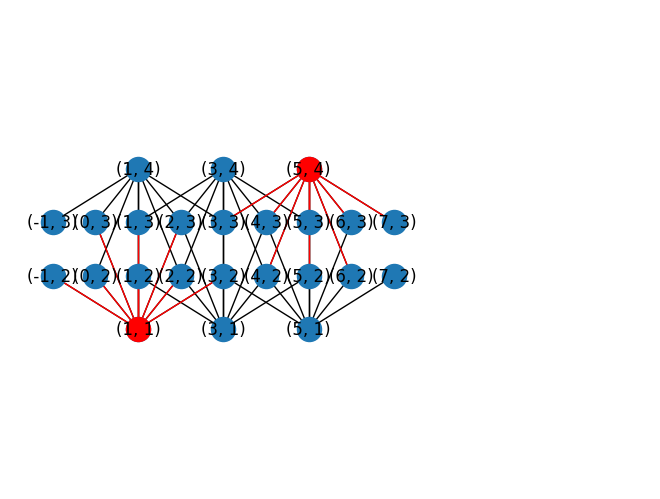

In [ ]:

G = nx.Graph()


points1 = [] #placement of lidars for one side
points2 = [] #placement of lidars for other side
points3 = [] #vertices to cover


for i in range(1, 6, 2):
    point = (i, 1)
    points1.append(point)

for i in range(1, 6, 2):
    point = (i, 4)
    points2.append(point)

for i in range(0, 7):
    for j in range(2, 4):
        point = (i, j)
        points3.append(point)

G.add_nodes_from(points1 + points2 + points3)


#edge that represents scope between lidar placement and vertices to cover
for node1 in points1:
  for j in range (node1[1]+1, node1[1]+3):
    if(j==node1[1]+1):
      for i in range(node1[0]-2, node1[0]+3):
        G.add_edge(tuple(node1), (i,j))
    if(j== node1[1]+2):
      for i in range(node1[0]-1, node1[0]+2):
        G.add_edge(tuple(node1), (i,j))
for node2 in points2:
  for j in range (node2[1]-2,node2[1]):
    if(j== node2[1]-2):
      for i in range(node2[0]-1, node2[0]+2):
        G.add_edge(tuple(node2), (i,j))
    if(j==node2[1]-1):
      for i in range(node2[0]-2, node2[0]+3):
        G.add_edge(tuple(node2), (i,j))
actE =[]
for node in S:
  for edge in G.edges(node):
    actE.append(edge)
# Draw the graph
pos = {node: node for node in G.nodes()}
nx.draw(G, pos, with_labels=True)

plt.xlim(-2, 13)
plt.ylim(-2, 7)

plt.xticks(range(1, 13))
plt.yticks(range(1, 7))
nx.draw_networkx_nodes(G, pos, S, node_color='red')
nx.draw_networkx_edges(G, pos, actE, edge_color='red')
plt.show()

In [ ]:
# #PREMIER TEST
# import os
# from platform import node
# import numpy as np
# import qiskit_optimization
# from docplex.mp.model import Model
# from qiskit_optimization.problems import QuadraticProgram
# import networkx as nx

# m = Model(name='BMW')
# pointsL = points1 + points2
# x = m.binary_var_dict(pointsL, name='x')
# m.objective_expr = sum(x[i] for i in pointsL) #minimize the placement of lidars
# m.objective_sense = 'min'

# #constraint on edge covering all vertices (allows to ensure that at least one lidar covers the area)
# for node in points3:
#   y = m.binary_var_dict(G.edges(node), name='y')
#   degre = len(y)
#   print(len(y))
#   m.add_constraint(sum(y[i] for i in G.edges(node)) <= degre)
#   m.add_constraint(sum(y[i] for i in G.edges(node)) >= 1)

# print(m.prettyprint())
# m.export_as_lp(basename="BMW", path=os.path.abspath(""))

# #Link the relation between edge activation and lidar placement activation
# for node in pointsL:
#  invEdges = [(i[1], i[0]) for i in G.edges(node)]#need to link the same edge from constraint 2 and the lidars placement
#  y = m.binary_var_dict(invEdges, name='y')
#  m.add_constraint(sum(y[i] - x[node] for i in invEdges if i[1] == node) == 0)

2
2
3
3
4
4
4
4
4
4
3
3
2
2
// This file has been generated by DOcplex
// model name is: BMW
// var contrainer section
dvar bool x[6];
dvar bool y[2];
dvar bool y[2];
dvar bool y[3];
dvar bool y[3];
dvar bool y[4];
dvar bool y[4];
dvar bool y[4];
dvar bool y[4];
dvar bool y[4];
dvar bool y[4];
dvar bool y[3];
dvar bool y[3];
dvar bool y[2];
dvar bool y[2];

minimize
 x_1_1 + x_3_1 + x_5_1 + x_1_4 + x_3_4 + x_5_4;
 
subject to {
 y_(0,_2)_(1,_1) + y_(0,_2)_(1,_4) <= 2;
 y_(0,_2)_(1,_1) + y_(0,_2)_(1,_4) >= 1;
 y_(0,_3)_(1,_1) + y_(0,_3)_(1,_4) <= 2;
 y_(0,_3)_(1,_1) + y_(0,_3)_(1,_4) >= 1;
 y_(1,_2)_(1,_1) + y_(1,_2)_(3,_1) + y_(1,_2)_(1,_4) <= 3;
 y_(1,_2)_(1,_1) + y_(1,_2)_(3,_1) + y_(1,_2)_(1,_4) >= 1;
 y_(1,_3)_(1,_1) + y_(1,_3)_(1,_4) + y_(1,_3)_(3,_4) <= 3;
 y_(1,_3)_(1,_1) + y_(1,_3)_(1,_4) + y_(1,_3)_(3,_4) >= 1;
 y_(2,_2)_(1,_1) + y_(2,_2)_(3,_1) + y_(2,_2)_(1,_4) + y_(2,_2)_(3,_4) <= 4;
 y_(2,_2)_(1,_1) + y_(2,_2)_(3,_1) + y_(2,_2)_(1,_4) + y_(2,_2)_(3,_4) >= 1;
 y_(2,_3)_(1,_